In [90]:
import sys
# setting path
sys.path.append('..')

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.ndimage.filters import gaussian_filter

from src import io, var, utils, fourier, lin_reg, reconstruction, physics, delaunay
from vis import plotter, cart_plot

import importlib
importlib.reload(io)
importlib.reload(var)
importlib.reload(utils)
importlib.reload(fourier)
importlib.reload(lin_reg)
importlib.reload(reconstruction)
importlib.reload(physics)
importlib.reload(delaunay)

importlib.reload(plotter)
importlib.reload(cart_plot)

<module 'vis.cart_plot' from '/home/ray/git-projects/spec_appx/notebooks/../vis/cart_plot.py'>

Setup objects and read data. Specify the extent of the lat-lon grid to be read in.

Data fetched...


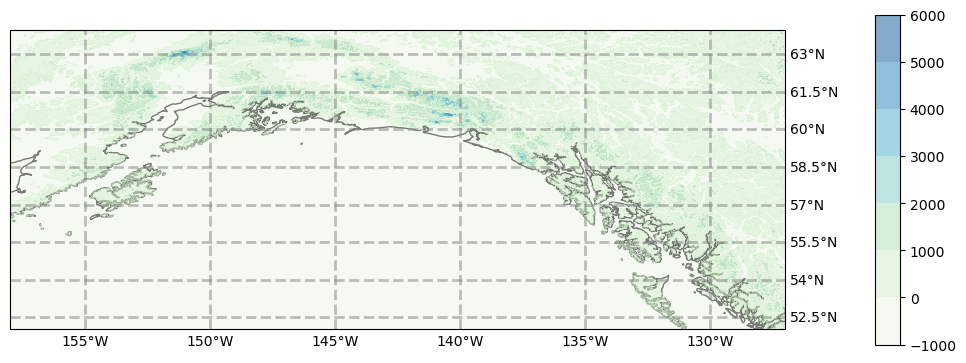

In [3]:
# initialise data objects
grid = var.grid()
topo = var.topo_cell()

# read grid
reader = io.ncdata()
fn = '../data/icon_compact.nc'
reader.read_dat(fn, grid)
grid.apply_f(utils.rad2deg) 

# read topography
fn = '../data/topo_compact.nc'
reader.read_dat(fn, topo)

# we only keep the topography that is inside this lat-lon extent.
lat_verts = np.array([52.,64.,64.])
lon_verts = np.array([-141.,-158.,-127.])

reader.read_topo(topo, topo, lon_verts, lat_verts)

topo.gen_mgrids()

# Plot the loaded topography...
cart_plot.lat_lon(topo)

Plot the Delaunay triangular, its vertices, and the computed centroids against the background of the topography.

Delaunay triangulation object created.
Number of triangles = 100


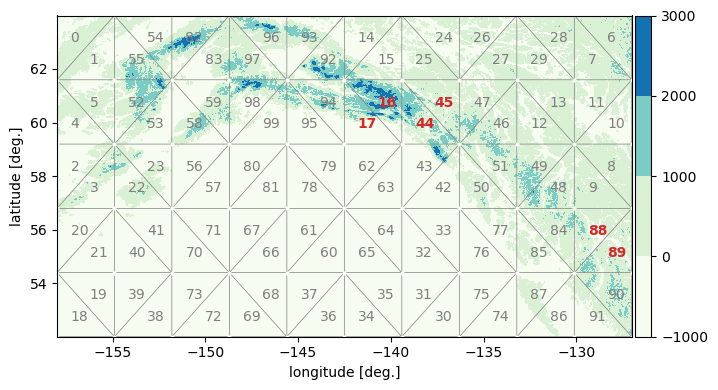

In [4]:
# Setup Delaunay triangulation domain.
tri = delaunay.get_decomposition(topo)

levels = np.linspace(-1000.0, 3000.0, 5)
cart_plot.lat_lon_delaunay(topo, tri, levels, label_idxs=True)

Prepare Delaunay simplices for the looping...

In [43]:
# Make circular vertex points, e.g. the last point is also the first point:
circ_tri_lat_verts = np.hstack((tri_lat_verts,tri_lat_verts[:,0].reshape(-1,1)))
circ_tri_lon_verts = np.hstack((tri_lon_verts,tri_lon_verts[:,0].reshape(-1,1)))

# Rescale everything to be between 0 and 1 (otherwise the function I copied off github above wouldn't work, lol).
circ_tri_lon_verts = rescale(circ_tri_lon_verts)
circ_tri_lat_verts = rescale(circ_tri_lat_verts)

# Let's just regenerate the lat-lon meshgrids to be safe... (in case we accidentally changed the values in the meantime).
topo.gen_mgrids()

# Now, we want to check for each point of the topography (given by it's lat-lon pair), whether the point is inside our triangle/polygon of interest.

# To do this, we setup a list that is of size: (no. of points x 2). 
lat_grid_tmp = np.expand_dims(np.copy(topo.lat_grid),-1)
lon_grid_tmp = np.expand_dims(np.copy(topo.lon_grid),-1)

lat_grid_tmp = rescale(lat_grid_tmp)
lon_grid_tmp = rescale(lon_grid_tmp)

lat_lon_mgrid = np.stack((lon_grid_tmp, lat_grid_tmp), axis=2).reshape(-1,2)

NameError: name 'tri_lat_verts' is not defined

Now we do the main looping.

In [5]:
def get_lat_lon_segments(lat_verts, lon_verts, cell, topo, triangle, rect=False):
    lat_max = get_closest_idx(lat_verts.max(), topo.lat)
    lat_min = get_closest_idx(lat_verts.min(), topo.lat)
    
    lon_max = get_closest_idx(lon_verts.max(), topo.lon)
    lon_min = get_closest_idx(lon_verts.min(), topo.lon)
    
    cell.lat = topo.lat[lat_min : lat_max]
    cell.lon = topo.lon[lon_min : lon_max]
    
    cell.topo = topo.topo[lat_min:lat_max, lon_min:lon_max]
    cell.gen_mgrids()
    
    if rect:
        cell.get_masked(mask=np.ones_like(cell.topo).astype('bool'))
    else:
        cell.get_masked(triangle=triangle)
    
    cell.topo_m -= cell.topo_m.mean()
                        
def get_closest_idx(val, arr):
    return int(np.argmin(np.abs(arr - val)))

In [136]:
importlib.reload(io)
importlib.reload(var)
importlib.reload(utils)
importlib.reload(fourier)
importlib.reload(lin_reg)
importlib.reload(reconstruction)
importlib.reload(physics)
# Setup the Fourier parameters and object.
nhi = 12
nhj = 12

fobj = fourier.f_trans(nhi,nhj)
fobj_tri = fourier.f_trans(nhi,nhj)

debug = False
plot = False

rect_set = np.sort([0,4,54,92,52,16,44,48,88,58,94])
# rect_set = np.sort([0,4])
print("rect_set = ", rect_set)
print("")

pmf_diff = []
idx_name = []

for rect_idx in rect_set:
    all_cells = np.zeros(2, dtype='object')
    for cnt, idx in enumerate(range(rect_idx,rect_idx+2)):

        # initialise cell object
        cell = var.topo_cell()

        print("computing idx:", idx)

        simplex_lat = tri.tri_lat_verts[idx]
        simplex_lon = tri.tri_lon_verts[idx]

        triangle = utils.triangle(simplex_lon, simplex_lat)
        get_lat_lon_segments(tri.tri_lat_verts[idx], tri.tri_lon_verts[idx], cell, topo, triangle, rect=False)

        if debug:
            print("cell.topo: ", cell.topo.min(), cell.topo.max())
            print("cell.lon: ", cell.lon.min(), cell.lon.max())
            print("cell.lat: ", cell.lat.min(), cell.lat.max())

        mask_tmp = np.copy(cell.mask)    

        # do fourier...
        fobj.do_full(cell)
        am, data_recons = lin_reg.do(fobj, cell, lmbda = 0.1)

        if debug: print("data_recons: ", data_recons.min(), data_recons.max())

        dat_2D = reconstruction.recon_2D(data_recons, cell)

        if debug: print("dat_2D: ", dat_2D.min(), dat_2D.max())

        fobj.get_freq_grid(am)
        freqs = np.abs(fobj.ampls)

        analysis = var.analysis()
        analysis.get_attrs(fobj, freqs)

        if cnt == 0:
            v_extent = [dat_2D.min(), dat_2D.max()]

        if plot:
            fs = (8.5,4.2)
            fig, axs = plt.subplots(1,2, figsize=fs)
            fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
            axs[0] = fig_obj.phys_panel(axs[0], dat_2D, title='T%i: Reconstruction' %idx, xlabel='longitude', ylabel='latitude', extent=[cell.lon.min(), cell.lon.max(), cell.lat.min(), cell.lat.max()], v_extent=v_extent)
            axs[1] = fig_obj.freq_panel(axs[1], freqs)
            plt.tight_layout()
            plt.savefig('output/T%i.pdf' %idx)
            plt.show()

        # print(freqs)
        ideal = physics.ideal_pmf(U=100.0, V=100.0)

        uw_pmf_freqs = ideal.compute_uw_pmf(analysis, summed=False)
        # uw_pmf_freqs = analysis.grid_kk_ll(fobj, uw_pmf_freqs)

        fq_cpy = np.copy(uw_pmf_freqs)
        # fq_cpy = uw_pmf_freqs
        # total_power = fq_cpy.sum()
        total_power = freqs.sum()

        ref_power = np.abs(np.fft.rfft2(cell.topo - cell.topo.mean())) / cell.topo.size
        ref_power = ref_power.sum()

        if debug:
            print("ref power =", ref_power)
            print("total power =", total_power)
            print("reg max, reg min =", fq_cpy.max(), fq_cpy.min())
            print("sum(fq_cpy) =", fq_cpy.sum())

        indices = []
        max_ampls = []

        for ii in range(35):
            max_idx = np.unravel_index(fq_cpy.argmax(), fq_cpy.shape)
            indices.append(max_idx)
            max_ampls.append(freqs[max_idx])
            max_val = fq_cpy[max_idx]
            fq_cpy[max_idx] = 0.0

            # if (sum(max_ampls) >= 0.1 * ref_power):
                # break
            # if (sum(max_ampls) >= 1.0 * total_power):
                # break
            # if sum(max_ampls) >= (total_power / 44000) * 44000:
                # break
            # if max_val < 0.01 * total_power:
            # if max_ampls[-1] <= 0.1 * max_ampls[0]:
                # break

        get_lat_lon_segments(tri.tri_lat_verts[idx], tri.tri_lon_verts[idx], cell, topo, triangle, rect=False)

        if debug: print(max_ampls, len(max_ampls), sum(max_ampls))
        k_idxs = [pair[1] for pair in indices]
        l_idxs = [pair[0] for pair in indices]

        fobj_tri.set_kls(k_idxs, l_idxs)
        fobj_tri.do_full(cell)

        am, data_recons = lin_reg.do(fobj_tri, cell, lmbda = 1e-6)

        fobj_tri.get_freq_grid(am)
        dat_2D = reconstruction.recon_2D(data_recons, cell)

        freqs = np.abs(fobj_tri.ampls)

        if debug: print("\n double reg. sum: ",freqs.sum())

        analysis = var.analysis()
        analysis.get_attrs(fobj_tri, freqs)
        analysis.recon = dat_2D

        cell.analysis = analysis

        # topo_tri = cell.topo * cell.mask
        # topo_tri -= topo_tri.mean()

        all_cells[cnt] = cell

        if plot:
            fs = (8.5,4.2)
            fig, axs = plt.subplots(1,2, figsize=fs)
            fig_obj = plotter.fig_obj(fig, fobj_tri.nhar_i, fobj_tri.nhar_j)
            axs[0] = fig_obj.phys_panel(axs[0], dat_2D, title='T%i: Reconstruction' %idx, xlabel='longitude', ylabel='latitude', extent=[cell.lon.min(), cell.lon.max(), cell.lat.min(), cell.lat.max()], v_extent=v_extent)
            axs[1] = fig_obj.freq_panel(axs[1], freqs)
            plt.tight_layout()
            plt.savefig('output/T%i.pdf' %idx)
            plt.show()
        
    cell0 = all_cells[0]
    cell1 = all_cells[1]
    
    topo_blur = gaussian_filter(cell0.topo - cell0.topo.mean(), sigma=0)
    
    ampls = np.fft.fft2(topo_blur)
    ampls = np.abs(ampls) / cell.topo.size
    
    
    # for now, we artifically initialise analysis object.
    wlat = np.diff(cell.lat).max()
    wlon = np.diff(cell.lon).max()

    sz = cell.topo.size
    kks = np.fft.fftfreq(cell.topo.shape[1])
    lls = np.fft.fftfreq(cell.topo.shape[0])

    kkg, llg = np.meshgrid(kks, lls)

    analysis = var.analysis()
    analysis.wlat = wlat
    analysis.wlon = wlon
    analysis.ampls = ampls
    analysis.kks = kkg#.reshape(-1,)#[1:] #/ kkg.size
    analysis.lls = llg#.reshape(-1,)#[1:] #/ llg.size

    ideal = physics.ideal_pmf(U=10.0, V=0.1)
    uw_ref = ideal.compute_uw_pmf(analysis, summed=False)

    uw0 = ideal.compute_uw_pmf(all_cells[0].analysis) #* all_cells[0].topo_m.size
    uw1 = ideal.compute_uw_pmf(all_cells[1].analysis) #* all_cells[1].topo_m.size
    
    uw01 = 0.5 * (uw0 + uw1)
    print("pmf tri1, tri2:", uw0, uw1)
    print("pmf ref, avg:", uw_ref.sum(), uw01)    
    
    print("")
    
    idx_name.append(rect_idx)
    pmf_diff.append((uw01 - uw_ref.sum()) / uw_ref.sum())

rect_set =  [ 0  4 16 44 48 52 54 58 88 92 94]

computing idx: 0


/home/ray/git-projects/spec_appx/notebooks/../src/physics.py:42: RuntimeWarning: invalid value encountered in true_divide
  mms = (N**2 * (kks**2 + lls**2) / omsq) - (kks**2 + lls**2)
/home/ray/git-projects/spec_appx/notebooks/../src/physics.py:47: RuntimeWarning: divide by zero encountered in true_divide
  Ag = 0.5 * ( ampls**2 * N**2 / np.sqrt(omsq) )
/home/ray/git-projects/spec_appx/notebooks/../src/physics.py:58: RuntimeWarning: invalid value encountered in true_divide
  cgz = self.N * kks * mms / (kks**2 + mms**2)**(3/2)


computing idx: 1


/home/ray/git-projects/spec_appx/notebooks/../src/physics.py:47: RuntimeWarning: invalid value encountered in true_divide
  Ag = 0.5 * ( ampls**2 * N**2 / np.sqrt(omsq) )


pmf tri1, tri2: 0.0011407434804462302 0.0012294764783756173
pmf ref, avg: 0.002262224603106812 0.0011851099794109236

computing idx: 4
computing idx: 5
pmf tri1, tri2: 0.0021653202198227547 0.0006435496590531735
pmf ref, avg: 0.0017447842334702205 0.001404434939437964

computing idx: 16
computing idx: 17
pmf tri1, tri2: 0.034434063673926533 0.06325601777821033
pmf ref, avg: 0.02218198442412277 0.048845040726068434

computing idx: 44
computing idx: 45
pmf tri1, tri2: 0.08027307456597646 0.01108217502768575
pmf ref, avg: 0.030651498269901534 0.0456776247968311

computing idx: 48
computing idx: 49
pmf tri1, tri2: 0.03331524949725639 0.015665736168067716
pmf ref, avg: 0.03302098016245361 0.024490492832662053

computing idx: 52
computing idx: 53
pmf tri1, tri2: 0.015227377415347083 0.011138775362201857
pmf ref, avg: 0.018863877273588257 0.01318307638877447

computing idx: 54
computing idx: 55
pmf tri1, tri2: 0.009570902446776226 0.01902531557124538
pmf ref, avg: 0.01602501792050561 0.014298

[0, 4, 16, 44, 48, 52, 54, 58, 88, 92, 94]
[-0.4761307176204519, -0.19506669506941382, 1.2020140214754527, 0.49022486257008135, -0.2583353761100986, -0.30114704429123945, -0.10776330610432915, -0.06966381617010795, -0.5945293353622215, 1.571724596739574, 1.416278208525723]


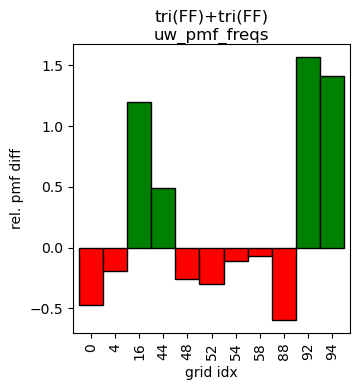

In [138]:
print(idx_name)
print(pmf_diff)
data = pd.DataFrame(pmf_diff,index=idx_name, columns=['values'])
fig, (ax1) = plt.subplots(1,1,sharex=True,
                         figsize=(3.7,4.0))

data['values'].plot(kind='bar', width=1.0, edgecolor='black', color=(data['values'] > 0).map({True: 'g', False: 'r'}))

plt.xlabel("grid idx")
plt.ylabel("rel. pmf diff")

cs1 = "rect(FF)+tri(FF)\nuw_pmf_freqs"
cs2 = "rect(FF)+tri(FF)\nfreqs"
cs3 = "tri(FF)+tri(FF)\nuw_pmf_freqs"
cs4 = "tri(FF)+tri(FF)\nfreqs"

title=cs3
plt.title(title, fontsize=12, pad=-10)
plt.tight_layout()
plt.savefig('./study/'+title.replace('\n','_')+'.png')
plt.show()

# Rect FF + Tri FF

In [22]:
importlib.reload(io)
importlib.reload(var)
importlib.reload(utils)
importlib.reload(fourier)
importlib.reload(lin_reg)
importlib.reload(reconstruction)
importlib.reload(physics)
# Setup the Fourier parameters and object.
nhi = 24
nhj = 24

fobj = fourier.f_trans(nhi,nhj)

idx = 82

# For each triangle...
# for idx in range(len(tri.simplices)):

cell.mask = mask_tmp

all_cells = np.zeros(2, dtype='object')
idx_name = []
# for cnt, idx in enumerate(range(0,2)):
# for cnt, idx in enumerate(range(2,4)):
# for cnt, idx in enumerate(range(4,6)):
# for cnt, idx in enumerate(range(6,8)):
# for cnt, idx in enumerate(range(8,10)):
# for cnt, idx in enumerate(range(10,12)):
# for cnt, idx in enumerate(range(12,14)):
# for cnt, idx in enumerate(range(14,16)):
# for cnt, idx in enumerate(range(16,18)):
# for cnt, idx in enumerate(range(18,20)):
# for cnt, idx in enumerate(range(20,22)):
# for cnt, idx in enumerate(range(58,60)):         # overestimation
# for cnt, idx in enumerate(range(48,50)):
# for cnt, idx in enumerate(range(88,90)):        # underestimation
# for cnt, idx in enumerate(range(42,44)):
# for cnt, idx in enumerate(range(44,46)):
# for cnt, idx in enumerate(range(54,56)):
# for cnt, idx in enumerate(range(82,84)):
for cnt, idx in enumerate(range(90,92)):
    if cnt == 0:
        cell = var.topo_cell()

        print("computing idx:", idx)
        simplex_lat = circ_tri_lat_verts[idx]
        simplex_lon = circ_tri_lon_verts[idx]

        polygon = np.array([list(item) for item in zip(simplex_lon, simplex_lat)])

        init_poly = mask_wrapper(polygon)
        cell.mask = np.array([init_poly(elem) for elem in lat_lon_mgrid]).reshape(topo.lon_grid.shape[0],topo.lon_grid.shape[1]).astype('bool_')

        mask_tmp = np.copy(cell.mask)
        get_lat_lon_segments(tri_lat_verts[idx], tri_lon_verts[idx], cell, topo, rect=True)

        # do fourier...
        fobj.do_full(cell)
        am, data_recons = lin_reg.do(fobj, cell, lmbda = 0.0)

        dat_2D = reconstruction.recon_2D(data_recons, cell)


        fobj.get_freq_grid(am)
        freqs = np.abs(fobj.ampls)

        analysis = var.analysis()
        analysis.get_attrs(fobj, freqs)

        fs = (8.5,4.2)
        fig, axs = plt.subplots(1,2, figsize=fs)
        fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
        axs[0] = fig_obj.phys_panel(axs[0], dat_2D, title='T%i: Reconstruction' %idx, xlabel='longitude', ylabel='latitude', extent=[cell.lon.min(), cell.lon.max(), cell.lat.min(), cell.lat.max()], v_extent=v_extent)
        axs[1] = fig_obj.freq_panel(axs[1], freqs)
        plt.tight_layout()
        plt.savefig('output/T%i.pdf' %idx)
        plt.show()

        # print(freqs)
        ideal = physics.ideal_pmf(U=10.0, V=1.0)

        uw_pmf_freqs = ideal.compute_uw_pmf(analysis, summed=False)
        # uw_pmf_freqs = analysis.grid_kk_ll(fobj, uw_pmf_freqs)

        fq_cpy = np.copy(freqs)
        # fq_cpy = uw_pmf_freqs
        # total_power = fq_cpy.sum()
        total_power = freqs.sum()

        ref_power = np.abs(np.fft.rfft2(cell.topo - cell.topo.mean())) / cell.topo.size
        ref_power = ref_power.sum()
        print("ref power =", ref_power)
        print("total power =", total_power)
        print("reg max, reg min =", fq_cpy.max(), fq_cpy.min())
        print("sum(fq_cpy) =", fq_cpy.sum())

        indices = []
        max_ampls = []

        if cnt == 0:
            nts = 30
        elif cnt == 1:
            nts = 8

        for ii in range(50):
            max_idx = np.unravel_index(fq_cpy.argmax(), fq_cpy.shape)
            indices.append(max_idx)
            max_ampls.append(freqs[max_idx])
            max_val = fq_cpy[max_idx]
            fq_cpy[max_idx] = 0.0

            # if (sum(max_ampls) >= 0.1 * ref_power):
                # break
            if (sum(max_ampls) >= 1.0 * total_power):
                break
            # if sum(max_ampls) >= (total_power / 44000) * 44000:
                # break
            # if max_val < 0.01 * total_power:
            if max_ampls[-1] <= 0.1 * max_ampls[0]:
                break
        
    #####################################

    cell = var.topo_cell()

    print("computing idx:", idx)
    simplex_lat = circ_tri_lat_verts[idx]
    simplex_lon = circ_tri_lon_verts[idx]

    polygon = np.array([list(item) for item in zip(simplex_lon, simplex_lat)])

    init_poly = mask_wrapper(polygon)
    cell.mask = np.array([init_poly(elem) for elem in lat_lon_mgrid]).reshape(topo.lon_grid.shape[0],topo.lon_grid.shape[1]).astype('bool_')
    # initialise cell object         
    get_lat_lon_segments(tri_lat_verts[idx], tri_lon_verts[idx], cell, topo, rect=False)
    
    print(max_ampls, len(max_ampls), sum(max_ampls))
    k_idxs = [pair[1] for pair in indices]
    l_idxs = [pair[0] for pair in indices]
    
    fobj.set_kls(k_idxs, l_idxs)
    fobj.do_full(cell)

    am, data_recons = lin_reg.do(fobj, cell, lmbda = 1e-6)

    fobj.get_freq_grid(am)
    dat_2D = reconstruction.recon_2D(data_recons, cell)

    freqs = np.abs(fobj.ampls)
    
    print("\n double reg. sum: ",freqs.sum())
    
    analysis = var.analysis()
    analysis.get_attrs(fobj, freqs)
    analysis.recon = dat_2D
    
    cell.analysis = analysis
    
    topo_tri = cell.topo * cell.mask
    topo_tri -= topo_tri.mean()
    
    all_cells[cnt] = cell

    if cnt == 0:
        v_extent = [dat_2D.min(), dat_2D.max()]
    
    fs = (8.5,4.2)
    fig, axs = plt.subplots(1,2, figsize=fs)
    fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
    axs[0] = fig_obj.phys_panel(axs[0], dat_2D, title='T%i: Reconstruction' %idx, xlabel='longitude', ylabel='latitude', extent=[cell.lon.min(), cell.lon.max(), cell.lat.min(), cell.lat.max()], v_extent=v_extent)
    axs[1] = fig_obj.freq_panel(axs[1], freqs)
    plt.tight_layout()
    plt.savefig('output/T%i.pdf' %idx)
    plt.show()
    
    idx_name.append(idx)
    
fs = (4.0,4.2)
fig, axs = plt.subplots(1,1, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
axs = fig_obj.phys_panel(axs, cell.topo, title='GMTED2010 orography', xlabel='longitude', ylabel='latitude', extent=[cell.lon.min(), cell.lon.max(), cell.lat.min(), cell.lat.max()])
plt.tight_layout()
plt.savefig('output/orig_topo_T%i_T%i.pdf' %(idx_name[0], idx_name[1]))
plt.show()

computing idx: 90


NameError: name 'circ_tri_lat_verts' is not defined

10.0 0.1
0.02218198442412277
0.1794515238582304 0.13493462812241094 0.15719307599032067


/home/ray/git-projects/spec_appx/notebooks/../src/physics.py:42: RuntimeWarning: invalid value encountered in true_divide
  mms = (N**2 * (kks**2 + lls**2) / omsq) - (kks**2 + lls**2)
/home/ray/git-projects/spec_appx/notebooks/../src/physics.py:47: RuntimeWarning: divide by zero encountered in true_divide
  Ag = 0.5 * ( ampls**2 * N**2 / np.sqrt(omsq) )
/home/ray/git-projects/spec_appx/notebooks/../src/physics.py:58: RuntimeWarning: invalid value encountered in true_divide
  cgz = self.N * kks * mms / (kks**2 + mms**2)**(3/2)
/home/ray/git-projects/spec_appx/notebooks/../src/physics.py:47: RuntimeWarning: invalid value encountered in true_divide
  Ag = 0.5 * ( ampls**2 * N**2 / np.sqrt(omsq) )


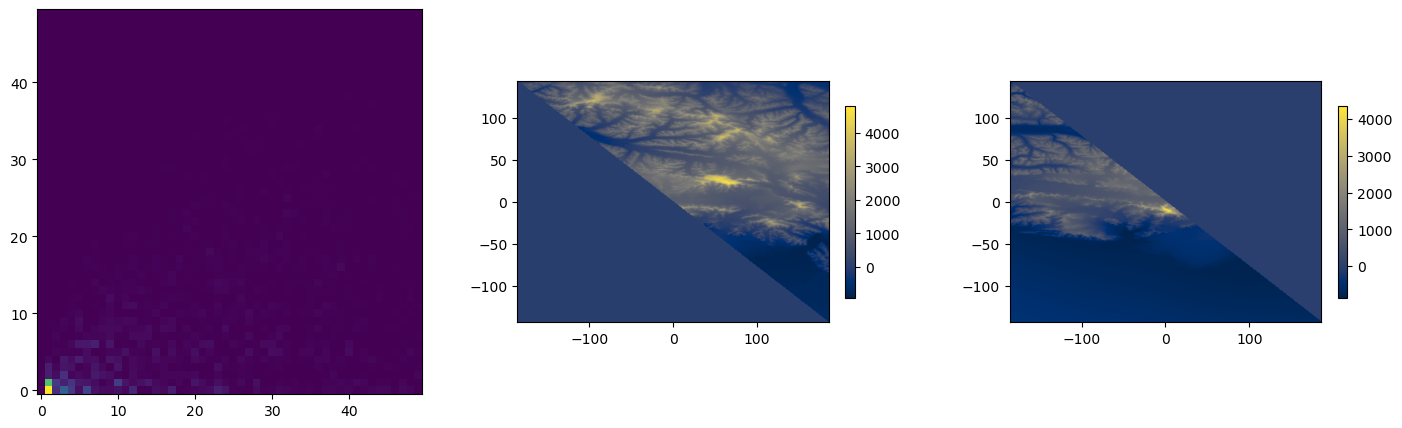

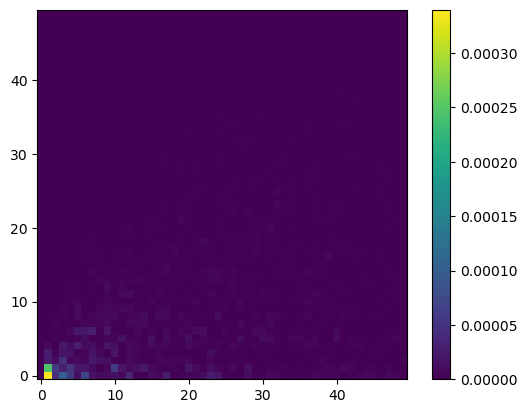

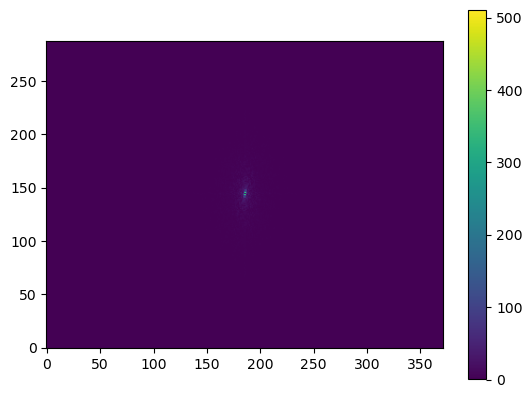

7363.519915550689


In [74]:
importlib.reload(physics)

cell0 = all_cells[0]
cell1 = all_cells[1]

topo_blur = gaussian_filter(cell0.topo - cell0.topo.mean(), sigma=0)
# topo_blur = cell.topo - cell.topo.mean()

# topo_test = cell0.analysis.recon + cell1.analysis.recon
# ampls = np.fft.fft2(topo_test)

# ampls = np.fft.fft2(cell.topo - cell.topo.mean())
ampls = np.fft.fft2(topo_blur)
ampls = np.abs(ampls) / cell.topo.size

# print("fft sum", ampls.sum())
# print(ampls)
ampls = ampls#.reshape(-1,)[1:]

wlat = np.diff(cell.lat).max()
wlon = np.diff(cell.lon).max()

sz = cell.topo.size
kks = np.fft.fftfreq(cell.topo.shape[1])
lls = np.fft.fftfreq(cell.topo.shape[0])

kkg, llg = np.meshgrid(kks, lls)

analysis = var.analysis()
analysis.wlat = wlat
analysis.wlon = wlon
analysis.ampls = ampls
analysis.kks = kkg#.reshape(-1,)#[1:] #/ kkg.size
analysis.lls = llg#.reshape(-1,)#[1:] #/ llg.size

ideal = physics.ideal_pmf(U=10.0, V=0.1)

print(ideal.U, ideal.V)

uw_ref = ideal.compute_uw_pmf(analysis, summed=False)
# uw_ref[0,0] = 0.0
print(uw_ref.sum())

uw0 = ideal.compute_uw_pmf(all_cells[0].analysis) #* all_cells[0].topo_m.size
uw1 = ideal.compute_uw_pmf(all_cells[1].analysis) #* all_cells[1].topo_m.size

uw01 = 0.5 * (uw0 + uw1) #/ all_cells[0].topo.size
print(uw0, uw1, uw01)

fs = (18,5)
fig, axs = plt.subplots(1,3, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
# axs[0] = fig_obj.phys_panel(axs[0], cell.topo)
# axs[0] = fig_obj.phys_panel(axs[0], topo_blur)
axs[0].imshow(uw_ref[:50,:50], origin='lower')
axs[1] = fig_obj.phys_panel(axs[1], cell.topo * cell0.mask)
axs[2] = fig_obj.phys_panel(axs[2], cell.topo * cell1.mask)
# axs[2] = fig_obj.freq_panel(axs[2], np.fft.fftshift(freqs), nhi=cell.topo.shape[1], nhj=cell.topo.shape[0])
plt.show()

plt.figure()
plt.imshow((uw_ref[:50,:50]), origin='lower')
plt.colorbar()
plt.show()


plt.figure()
plt.imshow(np.fft.fftshift(ampls), origin='lower')
plt.colorbar()
plt.show()

print(freqs.sum())

[15343002.06327461 15343002.06327461 12440692.32531508 12440692.32531508
  9441861.94341166  9441861.94341166  8941054.16611481  8941054.16611481
  5350689.60340243  5350689.60340243]


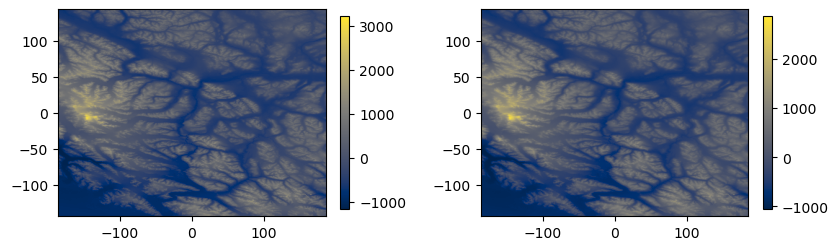

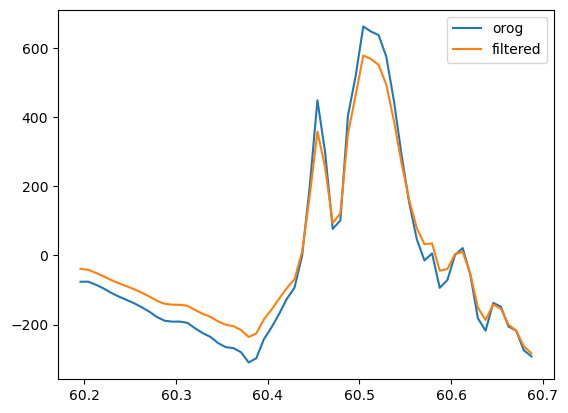

In [81]:
ampls = np.fft.fft2(topo_blur)
# ampls = np.abs(ampls) / cell.topo.size
Ks = np.fft.fftfreq(ampls.shape[1], d=0.08491180322081891).reshape(1,-1)
Ls = np.fft.fftfreq(ampls.shape[0], d=0.08491180322081891).reshape(-1,1)
# print(Ks.shape, Ls.shape)
# print(Ks)

kls = (Ks**2 + Ls**2)**0.5

# print(kls.shape)
ampls *= np.exp(-(kls / (2.0 * np.pi * 5))**0.5)
inverse = np.fft.ifft2(ampls).real

amtrunc = np.copy(ampls)
amtrunc = np.abs(amtrunc)
amtrunc = np.sort(amtrunc.reshape(-1,))[::-1][:10]
print(amtrunc)

fs = (10,5)
fig, axs = plt.subplots(1,2, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
# axs[0] = fig_obj.phys_panel(axs[0], cell.topo)
axs[0] = fig_obj.phys_panel(axs[0], topo_blur)
axs[1] = fig_obj.phys_panel(axs[1], inverse)
# axs[2] = fig_obj.freq_panel(axs[2], np.fft.fftshift(freqs), nhi=cell.topo.shape[1], nhj=cell.topo.shape[0])
plt.show()

plt.figure()

sidx, eidx = 120, 180
plt.plot(cell.lat[sidx:eidx], topo_blur[int(topo_blur.shape[0]/2)][sidx:eidx], label='orog')
plt.plot(cell.lat[sidx:eidx],inverse[int(topo_blur.shape[0]/2)][sidx:eidx], label='filtered')
plt.legend()
plt.show()

[1.53433146e+07 1.24409457e+07 9.44229946e+06 ... 4.64210991e+01
 4.23663079e+01 1.85536919e-09]
(288, 187)
(1, 187) (288, 1)
10.0 1.0
0.05111128031011058


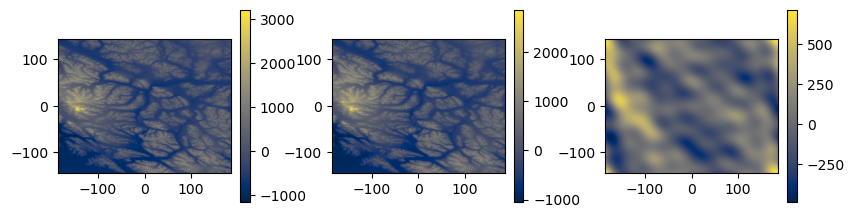

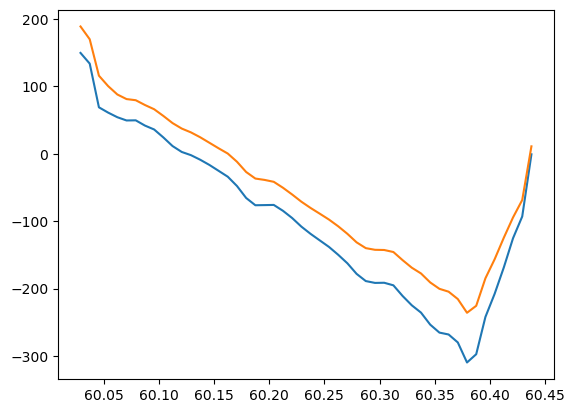

In [35]:
### ampls = np.fft.rfft2(topo_blur)
# ampls = np.abs(ampls) / cell.topo.size
Ks = np.fft.rfftfreq((ampls.shape[1] * 2)-1, d=0.08491180322081891).reshape(1,-1)
Ls = np.fft.fftfreq(ampls.shape[0], d=0.08491180322081891).reshape(-1,1)
# print(Ks.shape, Ls.shape)
# print(Ks)

kls = (Ks**2 + Ls**2)**0.5

ampls = np.fft.rfft2(topo_blur)

# print(kls.shape)
ampls *= np.exp(-(kls / (2.0 * np.pi * 5))**0.5)
inverse = np.fft.irfft2(ampls).real

amtrunc = np.copy(ampls)
# amtrunc = np.abs(amtrunc)
amtrunc = np.sort(np.abs(amtrunc).reshape(-1,))[::-1]#[:10]
print(amtrunc)
cutoff = amtrunc[50]

ampls_cpy = np.copy(ampls)
ampls_cpy[np.where(ampls_cpy <= cutoff)] = 0.0

inverse_trunc = np.fft.irfft2(ampls_cpy).real

wlat = np.diff(cell.lat).max()
wlon = np.diff(cell.lon).max()

# Ks = np.fft.rfftfreq((ampls.shape[1] * 2)-1,).reshape(1,-1)
# Ls = np.fft.fftfreq(ampls.shape[0],).reshape(-1,1)

sz = cell.topo.size
kks = Ks
lls = Ls

kkg, llg = np.meshgrid(kks, lls)

print(ampls.shape)
print(kks.shape, lls.shape)

analysis = var.analysis()
analysis.wlat = wlat
analysis.wlon = wlon
analysis.ampls = 2.0 * np.abs(ampls_cpy[np.where(ampls > cutoff)]) / sz
analysis.kks = kkg[np.where(ampls > cutoff)]
analysis.lls = llg[np.where(ampls > cutoff)]

ideal = physics.ideal_pmf(U=10.0, V=1.0)

print(ideal.U, ideal.V)

uw_ref = ideal.compute_uw_pmf(analysis)

print(uw_ref)

fs = (10,5)
fig, axs = plt.subplots(1,3, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
# axs[0] = fig_obj.phys_panel(axs[0], cell.topo)
axs[0] = fig_obj.phys_panel(axs[0], topo_blur)
axs[1] = fig_obj.phys_panel(axs[1], inverse)
axs[2] = fig_obj.phys_panel(axs[2], inverse_trunc)
# axs[2] = fig_obj.freq_panel(axs[2], np.fft.fftshift(freqs), nhi=cell.topo.shape[1], nhj=cell.topo.shape[0])
plt.show()

plt.figure()

sidx, eidx = 100, 150
plt.plot(cell.lat[sidx:eidx], topo_blur[int(topo_blur.shape[0]/2)][sidx:eidx])
plt.plot(cell.lat[sidx:eidx],inverse[int(topo_blur.shape[0]/2)][sidx:eidx])
plt.show()

In [15]:
import pandas as pd

XX = pd.Series([uw_ref,uw_50m,uw01],index=['full discrete\nfast-Fourier\ntransform','50-mode\nspectral\nrepresentation','unstructured\nspectral\napprox.'])
fig, (ax1) = plt.subplots(1,1,sharex=True,
                         figsize=(3.7,4.0))
# ax1.spines['bottom'].set_visible(False)
# ax1.tick_params(axis='x',which='both',bottom=False)
# ax2.spines['top'].set_visible(False)

bs = 700
ts = 37500

# ax2.set_ylim(0,bs)
ax1.set_ylim(0,0.04)

bars1 = ax1.bar(XX.index, XX.values, color=('C4', 'C5', 'C6'))
# bars2 = ax2.bar(XX.index, XX.values, color=('C0', 'C1', 'C2', 'r'))
ax1.bar_label(bars1, padding=3)
ax1.set_yticks(np.arange(0.0,0.05,0.01,))
# ax2.bar_label(bars2, padding=3)

# ax2.axhline(np.around(ref_sum, 2), ls='--', c='k')

# for tick in ax2.get_xticklabels():
    # tick.set_rotation(0)
# d = .015  
# kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
# ax1.plot((-d, +d), (-d, +d), **kwargs)      
# ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
# kwargs.update(transform=ax2.transAxes)  
# ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  
# ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

# for b1, b2 in zip(bars1, bars2):
#     posx = b2.get_x() + b2.get_width()/2.
#     if b2.get_height() > bs:
#         ax2.plot((posx-3*d, posx+3*d), (1 - d, 1 + d), color='k', clip_on=False,
#                  transform=ax2.get_xaxis_transform())
#     if b1.get_height() > ts:
#         ax1.plot((posx-3*d, posx+3*d), (- d, + d), color='k', clip_on=False,
#                  transform=ax1.get_xaxis_transform())
        
plt.title("pseudo-momentum fluxes ($\overline{u^\prime w^\prime}$)", fontsize=12, pad=-10)
plt.tight_layout()
plt.savefig('output/pmf_T%i_T%i_large.pdf' %(idx_name[0], idx_name[1]))
plt.show()

NameError: name 'uw_50m' is not defined

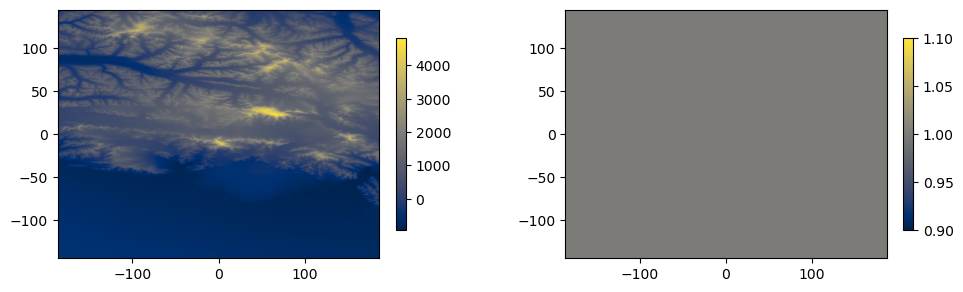

(288, 372)


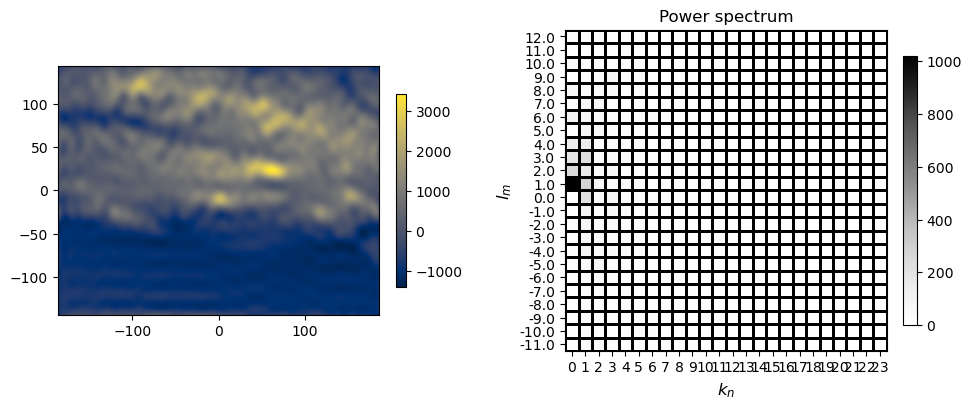

10427.249944107567
0.017737929376466885
(564,) (564,) (564,)
10.0 1.0
uw_50m = 0.01773792937646688


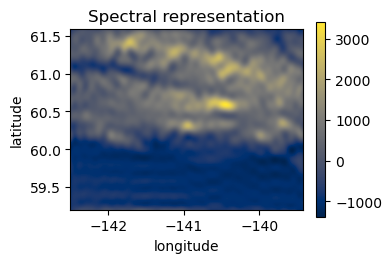

In [24]:
nhi = 24
nhj = 24

fobj = fourier.f_trans(nhi,nhj)

cell0 = all_cells[0]

cell0.mask[...] = 1

fs = (12,5)
fig, axs = plt.subplots(1,2, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
axs[0] = fig_obj.phys_panel(axs[0], cell0.topo)
axs[1] = fig_obj.phys_panel(axs[1], cell0.mask)
plt.show()

cell0.topo_m = cell0.topo[cell0.mask]
cell0.topo_m -= cell0.topo_m.mean()
cell0.lat_m = cell0.lat_grid[cell0.mask]
cell0.lon_m = cell0.lon_grid[cell0.mask]

fobj.do_full(cell0)
am, data_recons = lin_reg.do(fobj, cell0, lmbda = 0.0)

print(cell.topo.shape)

dat_2D = reconstruction.recon_2D(data_recons, cell0)

fobj.get_freq_grid(am)
freqs = np.abs(fobj.ampls)

cell0.analysis.get_attrs(fobj, freqs)

fs = (12,5)
fig, axs = plt.subplots(1,2, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
axs[0] = fig_obj.phys_panel(axs[0], dat_2D)
axs[1] = fig_obj.freq_panel(axs[1], freqs)
plt.show()

print(freqs.sum())

#################################

analysis = var.analysis()
analysis.get_attrs(fobj, freqs)

ideal = physics.ideal_pmf(U=10.0, V=1.0)

uw_pmf_freqs = ideal.compute_uw_pmf(analysis, summed=False)

print(uw_pmf_freqs.sum())

# ampls = fobj.ampls
# amtrunc = np.copy(freqs)
amtrunc = np.copy(uw_pmf_freqs)
amtrunc = np.sort(amtrunc.reshape(-1,))[::-1]#[:10]
# print(amtrunc)
cutoff = amtrunc[50]

ampls_cpy = np.copy(fobj.ampls)
# ampls_cpy[np.where(ampls_cpy <= cutoff)] = 0.0

# print(cutoff)
# print(len(freqs[np.where(freqs > cutoff)]))

wlat = np.diff(cell.lat).max()
wlon = np.diff(cell.lon).max()

sz = cell.topo.size
kks = fobj.m_i / (fobj.Ni)
lls = fobj.m_j / (fobj.Nj)

kkg, llg = np.meshgrid(kks, lls)

cell0.analysis.ampls = np.abs(ampls_cpy[np.where(freqs > cutoff)])
cell0.analysis.kks = kkg[np.where(freqs > cutoff)]
cell0.analysis.lls = llg[np.where(freqs > cutoff)]

ddd = cell0.analysis
print(ddd.kks.shape, ddd.lls.shape, ddd.ampls.shape)

ideal = physics.ideal_pmf(U=10.0, V=1.0)

print(ideal.U, ideal.V)

uw_50m = ideal.compute_uw_pmf(cell0.analysis)

print("uw_50m =", uw_50m)

fs = (4.0,4.2)
fig, axs = plt.subplots(1,1, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
axs = fig_obj.phys_panel(axs, dat_2D, title='Spectral representation', xlabel='longitude', ylabel='latitude', extent=[cell.lon.min(), cell.lon.max(), cell.lat.min(), cell.lat.max()])
plt.tight_layout()
plt.savefig('output/spec_rep_topo_T%i_T%i.pdf' %(idx_name[0], idx_name[1]))
plt.show()

In [16]:
print(fobj.Nj)
print(fobj.I)

print(fobj.Nj)
print(fobj.J)

287
[369 368 369 ... 367 368 369]
287
[  0   1   1 ... 286 286 286]


In [17]:
fft_ampls = np.fft.rfft2(cell0.topo - cell0.topo.mean())
# fft_ampls = np.fft.rfft2(topo_blur)
fft_ampls = np.abs(fft_ampls) / cell0.topo.size
fft_freqs = np.copy(fft_ampls)

# sz_fft = fft_ampls.size
# fft_add_ampls = fft_ampls.reshape(-1,)[1:int(sz_fft/2+1)] + fft_ampls.reshape(-1,)[int(sz_fft/2):][::-1]
# fft_add_ampls = np.append(fft_ampls[0], fft_add_ampls)

# print(np.sort(fft_add_ampls)[::-1])

print(fft_ampls.max())
print(freqs.max())

print(fft_ampls.sum())
print(freqs.sum())

ampls_sorted = np.sort(fft_ampls.reshape(-1,))[::-1][:288]
# print(ampls_sorted)
# ampls_summed = ampls_sorted[1::2] + ampls_sorted[:-1:2]

# print(ampls_summed)

print(2.0 * ampls_sorted[:26])

print(np.sort(freqs.reshape(-1,))[::-1][:26])
print(ampls_summed.sum())
print(np.sort(freqs.reshape(-1,))[::-1].sum())


# print(np.sort(fft_ampls.reshape(-1,))[::-1].sum())

# print(np.sort(freqs.reshape(-1,))[::-1].sum())


149.14041752777854
258.6477791826307
23728.18243165363
1913.943769035321
[298.28083506 241.8574983  185.10780854 173.04213087 173.04213087
 105.78408871 101.14385293  99.66945     89.34850478  77.31654614
  75.36632766  72.22061538  71.68840896  70.74420449  70.74420449
  68.66301156  64.07276982  62.61341939  60.1193949   58.07651112
  57.94426567  55.52314077  53.99492915  53.45126041  51.88971584
  50.79836106]
[258.64777918 172.49286337 146.87016938 108.91047713  97.70175944
  96.83736757  95.32183593  93.22270269  81.16603783  80.92415492
  72.33638222  67.29088202  58.67386704  57.02706062  53.58653191
  51.30618277  47.40157979  43.89696227  40.27449421  38.33046238
  37.66262367  34.27839466  33.18129301  29.29063414  17.31127089
   0.        ]


NameError: name 'ampls_summed' is not defined

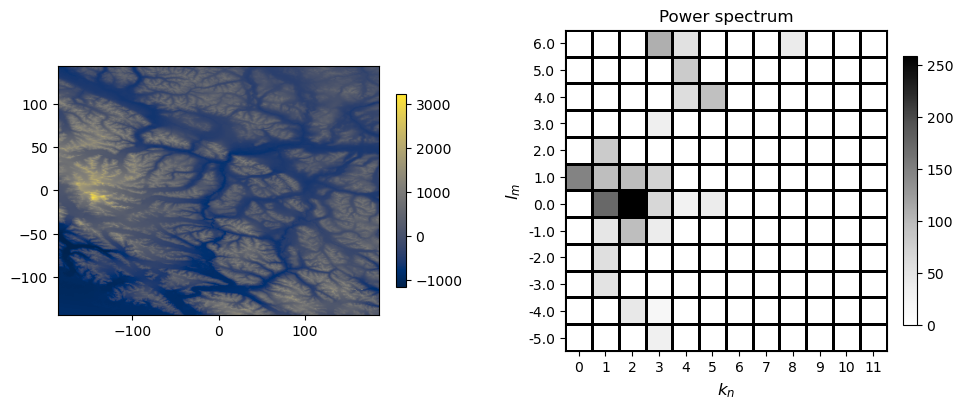

In [18]:
fft_ampls = np.fft.fft2(cell0.topo - cell0.topo.mean())

physical = np.fft.ifft2(fft_ampls).real

fs = (12,5)
fig, axs = plt.subplots(1,2, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
axs[0] = fig_obj.phys_panel(axs[0], physical)
axs[1] = fig_obj.freq_panel(axs[1], freqs)
plt.show()



AttributeError: 'topo_cell' object has no attribute 'I'